In [25]:
import gym
from gym import spaces
import numpy as np
import math

In [80]:
class RoomTemperatureControlEnv(gym.Env):
    def __init__(self, noise_int=0.5, noise_ext=0.5, k=1.0):
        super(RoomTemperatureControlEnv, self).__init__()
        self.insulation_factor = 0.1
        self.temperature_setpoint = 26.0
        self.action_space = spaces.Discrete(2)  # +0.1 or -0.1
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf]),
            high=np.array([np.inf, np.inf]),
            dtype=np.float32
        )
        self.state = None
        self.noise_int = noise_int
        self.noise_ext = noise_ext
        self.k = k

    def reset(self):
        self.state = np.array([15.0, self.external_temperature(0)], dtype=np.float32)
        self.time = 0
        return self._get_obs()

    def step(self, action):
        action_value = 0.1 if action == 1 else -0.1
        internal_temp, external_temp = self.state
        internal_temp += self.insulation_factor * (external_temp - internal_temp) + action_value
        self.time += 1
        self.state = np.array([internal_temp, self.external_temperature(self.time)], dtype=np.float32)
        done = self.time >= 1440
        deviation = abs(internal_temp - self.temperature_setpoint)
        if abs(internal_temp - self.temperature_setpoint) <= 3:
            reward = 50
        elif deviation > 2:
            reward = -deviation * 10
        else:
            reward = -deviation * 1
            
        return self._get_obs(), reward, done, {}

    def external_temperature(self, t):
        return 20 + 10 * np.sin(2 * np.pi * t / (24 * 60))

    def _get_obs(self):
        internal_temp, external_temp = self.state
        noise_int = np.random.normal(0, self.noise_int)
        noise_ext = np.random.normal(0, self.noise_ext)
        return np.array([internal_temp + noise_int, external_temp + noise_ext], dtype=np.float32)


In [82]:
import gym
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # discount rate
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # higher minimum epsilon for more exploration
        self.epsilon_decay = 0.995  # slower decay rate
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                target = (reward + self.gamma * torch.max(self.model(next_state)[0]).item())
            target_f = self.model(state)
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(target_f, self.model(state))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

# Training the DQN model
env = RoomTemperatureControlEnv()  # Ensure your environment is set correctly
agent = DQNAgent(state_size=2, action_size=2)
done = False
batch_size = 32
EPISODES = 10  # Increase the number of episodes for better training

for e in range(EPISODES):
    state = env.reset()
    total_reward = 0
    for time in range(1440):  # One day simulation
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e+1}/{EPISODES}, total reward: {total_reward:.2f}, epsilon: {agent.epsilon:.2f}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)


episode: 1/10, total reward: -77725.50, epsilon: 0.01
episode: 2/10, total reward: -57980.77, epsilon: 0.01
episode: 3/10, total reward: -57998.26, epsilon: 0.01
episode: 4/10, total reward: -83297.11, epsilon: 0.01
episode: 5/10, total reward: -83262.14, epsilon: 0.01
episode: 6/10, total reward: -58639.44, epsilon: 0.01
episode: 7/10, total reward: -57969.39, epsilon: 0.01
episode: 8/10, total reward: -62816.41, epsilon: 0.01
episode: 9/10, total reward: -83107.70, epsilon: 0.01
episode: 10/10, total reward: -63593.58, epsilon: 0.01


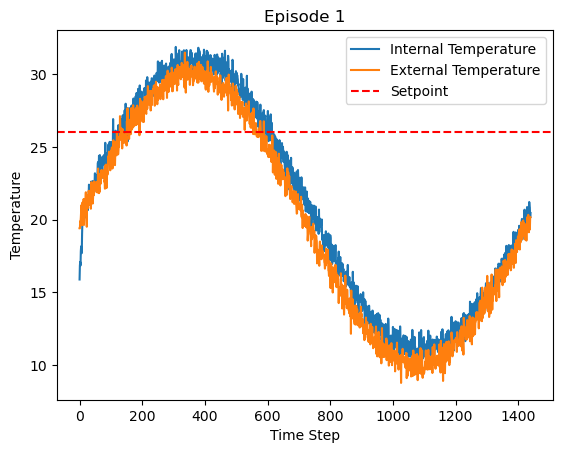

In [83]:
import matplotlib.pyplot as plt
# Function to track and plot the internal and external temperatures
def track_temperature(agent, env, episodes=1):
    for episode in range(episodes):
        state = env.reset()
        done = False
        internal_temps = []
        external_temps = []
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            internal_temps.append(next_state[0])  # Assuming the first element is the internal temperature
            external_temps.append(next_state[1])  # Assuming the second element is the external temperature
            state = next_state

        plt.plot(internal_temps, label='Internal Temperature')
        plt.plot(external_temps, label='External Temperature')
        plt.axhline(y=env.temperature_setpoint, color='r', linestyle='--', label='Setpoint')
        plt.xlabel('Time Step')
        plt.ylabel('Temperature')
        plt.title(f'Episode {episode + 1}')
        plt.legend()
        plt.show()

# Plotting the internal temperature for the last episode
track_temperature(agent, env, episodes=1)


In [97]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the environment
class RoomTemperatureControlEnv(gym.Env):
    def __init__(self, noise_int=0.5, noise_ext=0.5, k=1.0, lambda_=1.0):
        super(RoomTemperatureControlEnv, self).__init__()
        self.insulation_factor = 0.1  # Adjusted insulation factor
        self.temperature_setpoint = 26.0  # Setpoint temperature
        self.action_space = spaces.Discrete(2)  # -0.1,+0.1
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf]),
            high=np.array([np.inf, np.inf]),
            dtype=np.float32
        )
        self.state = None
        self.noise_int = noise_int
        self.noise_ext = noise_ext
        self.k = k
        self.lambda_ = lambda_  # Weighting factor for energy penalty

    def reset(self):
        self.state = np.array([15.0, self.external_temperature(0)], dtype=np.float32)
        self.time = 0
        return self._get_obs()

    def step(self, action):
        action_value = 0.1 if action == 1 else -0.1
        internal_temp, external_temp = self.state
        internal_temp += self.insulation_factor * (external_temp - internal_temp) + action_value
        self.time += 1
        self.state = np.array([internal_temp, self.external_temperature(self.time)], dtype=np.float32)
        done = self.time >= 1440
        reward = self.calculate_reward(internal_temp, external_temp)
        return self._get_obs(), reward, done, {}

    def external_temperature(self, t):
        return 20 + 10 * np.sin(2 * np.pi * t / (24 * 60))  # Keep the original amplitude

    def _get_obs(self):
        internal_temp, external_temp = self.state
        noisy_internal = internal_temp + np.random.normal(0, self.noise_int)
        noisy_external = external_temp + np.random.normal(0, self.noise_ext)
        return np.array([noisy_internal, noisy_external], dtype=np.float32)

    def calculate_reward(self, internal_temp, external_temp):
        distance_from_setpoint = internal_temp - self.temperature_setpoint
        energy_penalty = self.lambda_ * abs(internal_temp - external_temp)
        return - (distance_from_setpoint ** 2 + energy_penalty)

In [99]:
# Define the DQN
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=0.001, batch_size=64, memory_size=1000000, target_update=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.lr = lr
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.target_update = target_update
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQNetwork(state_size, action_size).to(self.device)
        self.target_net = DQNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()
        self.update_target_network()

        self.steps_done = 0
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        self.training_rewards = []
        self.episode_durations = []

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.action_size))
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.policy_net(states).gather(1, actions).squeeze(1)
        with torch.no_grad():
            max_next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * max_next_q_values * (1 - dones))

        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps_done % self.target_update == 0:
            self.update_target_network()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.steps_done += 1

    def train(self, env, episodes=10):
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                self.replay()
            self.training_rewards.append(total_reward)
            self.episode_durations.append(env.time)
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

    def evaluate(self, env, episodes=100):
        rewards = []
        for episode in range(episodes):
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.act(state)
                state, reward, done, _ = env.step(action)
                total_reward += reward
            rewards.append(total_reward)
        average_reward = np.mean(rewards)
        return average_reward, rewards

In [111]:
def plot_training_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards over Training Episodes')
    plt.show()

def track_temperature_and_actions(agent, env, episodes=1):
    for episode in range(episodes):
        state = env.reset()
        done = False
        internal_temps = []
        external_temps = []
        actions = []
        while not done:
            action = agent.act(state)
            state, _, done, _ = env.step(action)
            internal_temps.append(state[0])  
            external_temps.append(state[1])  
            actions.append(action)
        plt.plot(internal_temps, label='Internal Temperature')
        plt.plot(external_temps, label='External Temperature', linestyle='--')
        plt.axhline(y=env.temperature_setpoint, color='r', linestyle='--', label='Setpoint')
        plt.xlabel('Time Step')
        plt.ylabel('Temperature')
        plt.title(f'Episode {episode + 1}')
        plt.legend()
        plt.show()
        plt.plot(actions, label='Actions')
        plt.xlabel('Time Step')
        plt.ylabel('Action')
        plt.title(f'Actions in Episode {episode + 1}')
        plt.legend()
        plt.show()

Episode 1/40, Total Reward: -136793.14092748694, Epsilon: 0.01
Episode 2/40, Total Reward: -111989.47698884901, Epsilon: 0.01
Episode 3/40, Total Reward: -112942.08489363486, Epsilon: 0.01
Episode 4/40, Total Reward: -112244.88372370979, Epsilon: 0.01
Episode 5/40, Total Reward: -120301.68161547644, Epsilon: 0.01
Episode 6/40, Total Reward: -116853.88630291756, Epsilon: 0.01
Episode 7/40, Total Reward: -119970.39786528729, Epsilon: 0.01
Episode 8/40, Total Reward: -110492.4167179209, Epsilon: 0.01
Episode 9/40, Total Reward: -110790.2525971854, Epsilon: 0.01
Episode 10/40, Total Reward: -111420.4627805161, Epsilon: 0.01
Episode 11/40, Total Reward: -110133.92881433896, Epsilon: 0.01
Episode 12/40, Total Reward: -110807.26383519481, Epsilon: 0.01
Episode 13/40, Total Reward: -110041.05166183828, Epsilon: 0.01
Episode 14/40, Total Reward: -110053.4562954223, Epsilon: 0.01
Episode 15/40, Total Reward: -110347.87997011012, Epsilon: 0.01
Episode 16/40, Total Reward: -110076.69400135732, Eps

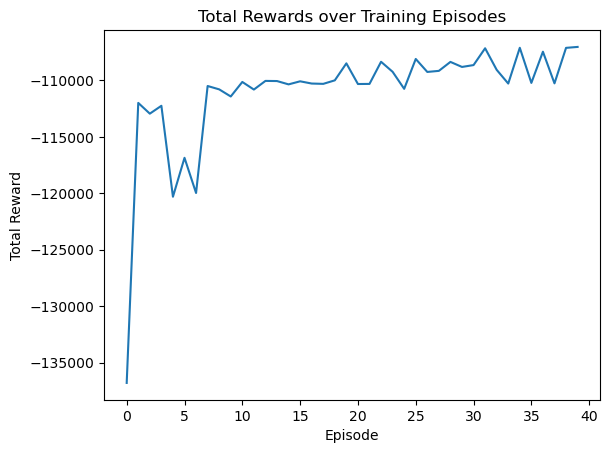

Average Reward over 100 episodes: -110088.10531198185


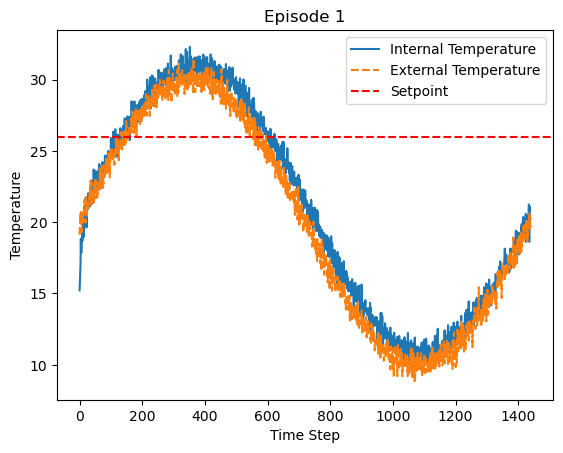

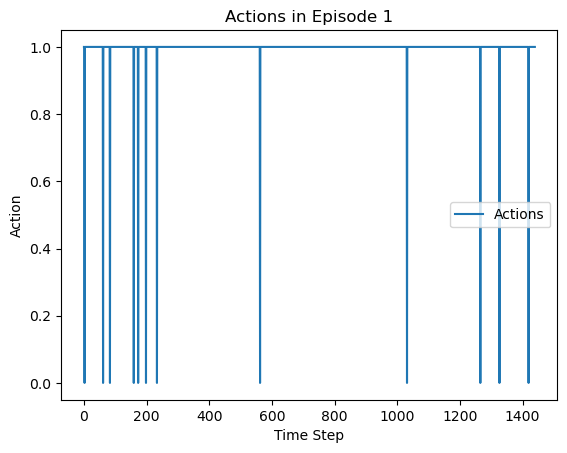

In [115]:
# Train and evaluate the DQN agent
env = RoomTemperatureControlEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)
dqn_agent.train(env, episodes=40)

# Plot training rewards
plot_training_rewards(dqn_agent.training_rewards)

# Evaluate and track performance
average_reward, rewards = dqn_agent.evaluate(env)
print(f"Average Reward over {len(rewards)} episodes: {average_reward}")
track_temperature_and_actions(dqn_agent, env)

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the environment
class RoomTemperatureControlEnv(gym.Env):
    def __init__(self, noise_int=0.5, noise_ext=0.5, k=1.0, lambda_=1.0):
        super(RoomTemperatureControlEnv, self).__init__()
        self.insulation_factor = 0.1  # Adjusted insulation factor
        self.temperature_setpoint = 26.0  # Setpoint temperature
        self.action_space = spaces.Discrete(2) # 2 actions: increase or decrease temperature
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf]),
            high=np.array([np.inf, np.inf]),
            dtype=np.float32
        )
        self.state = None
        self.noise_int = noise_int
        self.noise_ext = noise_ext
        self.k = k
        self.lambda_ = lambda_  # Weighting factor for time penalty

    def reset(self):
        self.state = np.array([15.0, self.external_temperature(0)], dtype=np.float32)
        self.time = 0
        return self._get_obs()

    def step(self, action):
        action_value = 0.1 if action == 1 else -0.1
        internal_temp, external_temp = self.state
        internal_temp += self.insulation_factor * (external_temp - internal_temp) + action_value
        self.time += 1
        self.state = np.array([internal_temp, self.external_temperature(self.time)], dtype=np.float32)
        done = self.time >= 1440
        reward = self.calculate_reward(internal_temp)
        return self._get_obs(), reward, done, {}

    def external_temperature(self, t):
        return 20 + 10 * np.sin(2 * np.pi * t / (24 * 60))  # Keep the original amplitude

    def _get_obs(self):
        internal_temp, external_temp = self.state
        noisy_internal = internal_temp + np.random.normal(0, self.noise_int)
        noisy_external = external_temp + np.random.normal(0, self.noise_ext)
        return np.array([noisy_internal, noisy_external], dtype=np.float32)

    def calculate_reward(self, internal_temp):
        distance_from_setpoint = internal_temp - self.temperature_setpoint
        time_penalty = self.lambda_ * (self.time if abs(distance_from_setpoint) > 1 else 0)
        return distance_from_setpoint ** 2 + time_penalty


# Define the DQN
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Train and evaluate the DQN agent
env = RoomTemperatureControlEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)
dqn_agent.train(env, episodes=1000)

# Plot training rewards
plot_training_rewards(dqn_agent.training_rewards)

# Evaluate and track performance
average_reward, rewards = dqn_agent.evaluate(env)
print(f"Average Reward over {len(rewards)} episodes: {average_reward}")
track_temperature_and_actions(dqn_agent, env)

Episode 1/40, Total Reward: 1131092.9635951912, Epsilon: 0.01
Episode 2/40, Total Reward: 1104589.7167691346, Epsilon: 0.01
Episode 3/40, Total Reward: 1097179.334468723, Epsilon: 0.01
Episode 4/40, Total Reward: 1104399.653006942, Epsilon: 0.01
Episode 5/40, Total Reward: 1107499.3074863986, Epsilon: 0.01
Episode 6/40, Total Reward: 1110304.9622461128, Epsilon: 0.01
Episode 7/40, Total Reward: 1110053.9249355497, Epsilon: 0.01
Episode 8/40, Total Reward: 1090577.6809286328, Epsilon: 0.01
Episode 9/40, Total Reward: 1113623.9362685583, Epsilon: 0.01
Episode 10/40, Total Reward: 1107861.0184216008, Epsilon: 0.01
Episode 11/40, Total Reward: 1108816.4781688799, Epsilon: 0.01
Episode 12/40, Total Reward: 1109515.198748726, Epsilon: 0.01
Episode 13/40, Total Reward: 1109558.413057613, Epsilon: 0.01
Episode 14/40, Total Reward: 1107992.3194426377, Epsilon: 0.01
Episode 15/40, Total Reward: 1107940.058495606, Epsilon: 0.01
Episode 16/40, Total Reward: 1107292.7809056637, Epsilon: 0.01
Episod

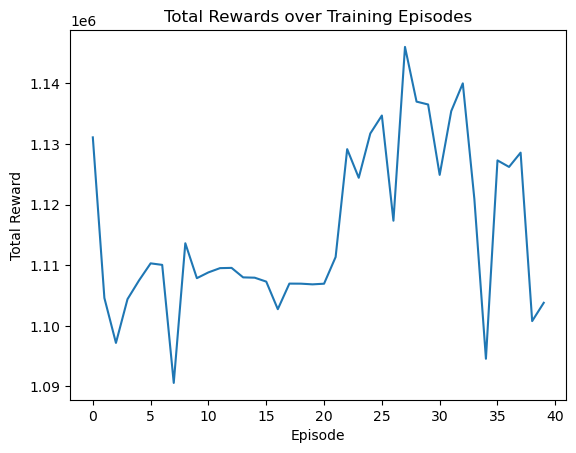

Average Reward over 100 episodes: 1106879.2987756697


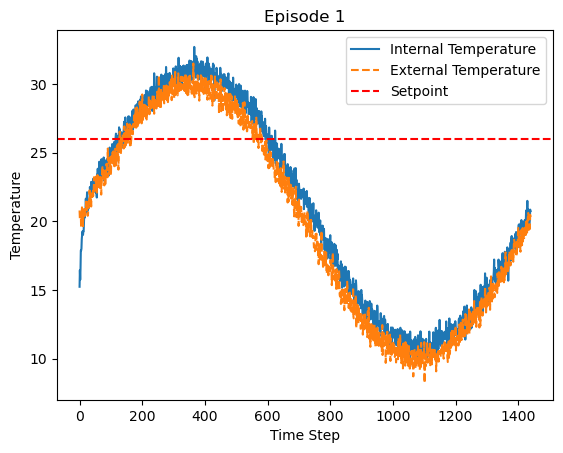

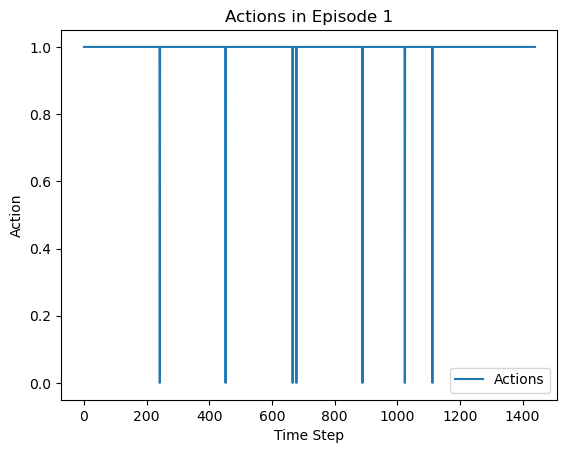

In [129]:
# Train and evaluate the DQN agent
env = RoomTemperatureControlEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)
dqn_agent.train(env, episodes=40)

# Plot training rewards
plot_training_rewards(dqn_agent.training_rewards)

# Evaluate and track performance
average_reward, rewards = dqn_agent.evaluate(env)
print(f"Average Reward over {len(rewards)} episodes: {average_reward}")
track_temperature_and_actions(dqn_agent, env)

In [460]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the environment
class RoomTemperatureControlEnv(gym.Env):
    def __init__(self, noise_int=0.5, noise_ext=0.5, k=1.0, lambda_=3.0):
        super(RoomTemperatureControlEnv, self).__init__()
        self.insulation_factor = 0.1  # Adjusted insulation factor
        self.temperature_setpoint = 26.0  # Setpoint temperature
        self.action_space = spaces.Discrete(2)  # -0.1,+0.1
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf]),
            high=np.array([np.inf, np.inf]),
            dtype=np.float32
        )
        self.state = None
        self.noise_int = noise_int
        self.noise_ext = noise_ext
        self.k = k
        self.lambda_ = lambda_  # Weighting factor for energy penalty

    def reset(self):
        self.state = np.array([15.0, self.external_temperature(0)], dtype=np.float32)
        self.time = 0
        return self._get_obs()

    def step(self, action):
        action_value = 0.1 if action == 1 else -0.1
        internal_temp, external_temp = self.state
        internal_temp += self.insulation_factor * (external_temp - internal_temp) + action_value
        self.time += 1
        self.state = np.array([internal_temp, self.external_temperature(self.time)], dtype=np.float32)
        done = self.time >= 1440
        reward = self.calculate_reward(internal_temp, external_temp)
        return self._get_obs(), reward, done, {}

    def external_temperature(self, t):
        return 20 + 10 * np.sin(2 * np.pi * t / (24 * 60))  # Keep the original amplitude

    def _get_obs(self):
        internal_temp, external_temp = self.state
        noisy_internal = internal_temp + np.random.normal(0, self.noise_int)
        noisy_external = external_temp + np.random.normal(0, self.noise_ext)
        return np.array([noisy_internal, noisy_external], dtype=np.float32)

    def calculate_reward(self, internal_temp, external_temp):
        distance_from_setpoint = internal_temp - self.temperature_setpoint
        return -abs(distance_from_setpoint)

Episode 1/5000, Total Reward: -11252.97969169618, Epsilon: 0.01
Episode 2/5000, Total Reward: -11428.042973613738, Epsilon: 0.01
Episode 3/5000, Total Reward: -10987.342372131347, Epsilon: 0.01
Episode 4/5000, Total Reward: -10663.54115695952, Epsilon: 0.01
Episode 5/5000, Total Reward: -10467.47942848206, Epsilon: 0.01
Episode 6/5000, Total Reward: -10527.39573040011, Epsilon: 0.01
Episode 7/5000, Total Reward: -10206.581656074533, Epsilon: 0.01
Episode 8/5000, Total Reward: -10365.4664414406, Epsilon: 0.01
Episode 9/5000, Total Reward: -10681.749938011168, Epsilon: 0.01
Episode 10/5000, Total Reward: -10733.410492229475, Epsilon: 0.01
Episode 11/5000, Total Reward: -11001.875584602354, Epsilon: 0.01
Episode 12/5000, Total Reward: -10647.68820981979, Epsilon: 0.01
Episode 13/5000, Total Reward: -10717.141898250584, Epsilon: 0.01
Episode 14/5000, Total Reward: -10781.027728462217, Epsilon: 0.01
Episode 15/5000, Total Reward: -10530.48833179473, Epsilon: 0.01
Episode 16/5000, Total Rewa

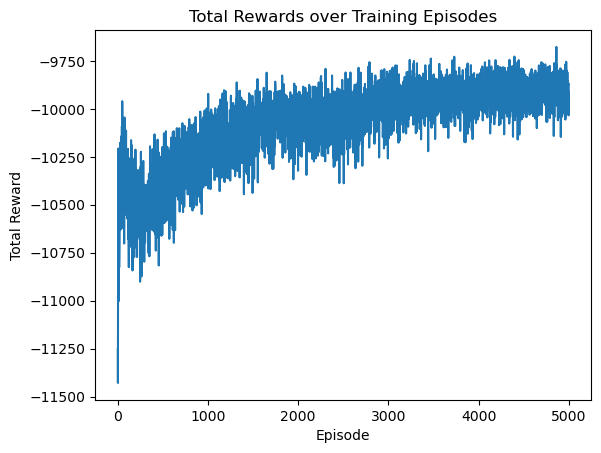

Average Reward over 100 episodes: -9602.959734181406


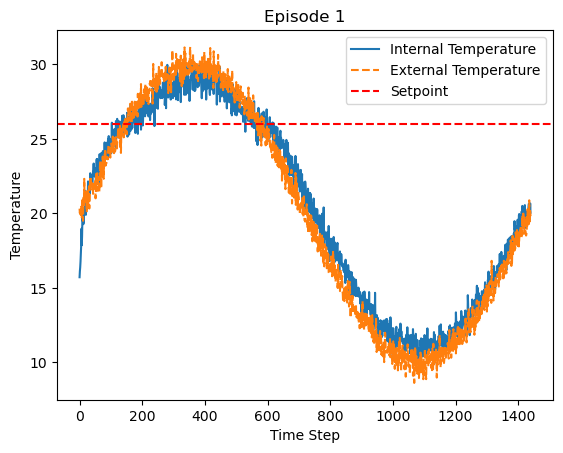

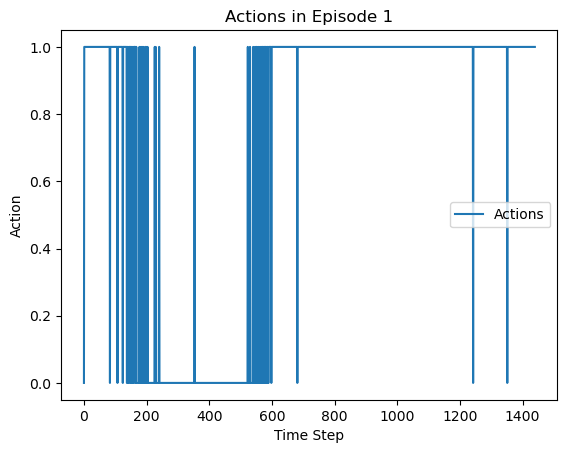

In [466]:
# Train and evaluate the DQN agent
env = RoomTemperatureControlEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)
dqn_agent.train(env, episodes=5000)

# Plot training rewards
plot_training_rewards(dqn_agent.training_rewards)

# Evaluate and track performance
average_reward, rewards = dqn_agent.evaluate(env)
print(f"Average Reward over {len(rewards)} episodes: {average_reward}")
track_temperature_and_actions(dqn_agent, env)

In [346]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the environment
class RoomTemperatureControlEnv(gym.Env):
    def __init__(self, noise_int=0.5, noise_ext=0.5, k=1.0, lambda_=3.0):
        super(RoomTemperatureControlEnv, self).__init__()
        self.insulation_factor = 0.1  # Adjusted insulation factor
        self.temperature_setpoint = 26.0  # Setpoint temperature
        self.action_space = spaces.Discrete(2)  # -0.1,+0.1
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf]),
            high=np.array([np.inf, np.inf]),
            dtype=np.float32
        )
        self.state = None
        self.noise_int = noise_int
        self.noise_ext = noise_ext
        self.k = k
        self.lambda_ = lambda_  # Weighting factor for energy penalty

    def reset(self):
        self.state = np.array([15.0, self.external_temperature(0)], dtype=np.float32)
        self.time = 0
        return self._get_obs()

    def step(self, action):
        action_value = 0.1 if action == 1 else -0.1
        internal_temp, external_temp = self.state
        internal_temp += self.insulation_factor * (external_temp - internal_temp) + action_value
        self.time += 1
        self.state = np.array([internal_temp, self.external_temperature(self.time)], dtype=np.float32)
        done = self.time >= 1440
        reward = self.calculate_reward(internal_temp, external_temp)
        return self._get_obs(), reward, done, {}

    def external_temperature(self, t):
        return 20 + 10 * np.sin(2 * np.pi * t / (24 * 60))  # Keep the original amplitude

    def _get_obs(self):
        internal_temp, external_temp = self.state
        noisy_internal = internal_temp + np.random.normal(0, self.noise_int)
        noisy_external = external_temp + np.random.normal(0, self.noise_ext)
        return np.array([noisy_internal, noisy_external], dtype=np.float32)

    def calculate_reward(self, internal_temp, external_temp):
        additional_reward = 0
        distance_from_setpoint = internal_temp - self.temperature_setpoint
        #energy_penalty = self.lambda_ * abs(internal_temp - external_temp)
        if abs(internal_temp - self.temperature_setpoint) <= 0.5:
            additional_reward += 10
        if abs(abs(internal_temp - self.temperature_setpoint) - abs(external_temp - self.temperature_setpoint)) >= 1.0:
            additional_reward += 5
        elif abs(internal_temp - self.temperature_setpoint) < abs(external_temp - self.temperature_setpoint):
            additional_reward += 1
        else:
            additional_reward += 0
        return -math.log(distance_from_setpoint**2) + additional_reward

In [444]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the environment
class RoomTemperatureControlEnv(gym.Env):
    def __init__(self, noise_int=0.5, noise_ext=0.5, k=1.0, lambda_=3.0):
        super(RoomTemperatureControlEnv, self).__init__()
        self.insulation_factor = 0.1  # Adjusted insulation factor
        self.temperature_setpoint = 26.0  # Setpoint temperature
        self.action_space = spaces.Discrete(2)  # -0.1,+0.1
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf]),
            high=np.array([np.inf, np.inf]),
            dtype=np.float32
        )
        self.state = None
        self.noise_int = noise_int
        self.noise_ext = noise_ext
        self.k = k
        self.lambda_ = lambda_  # Weighting factor for energy penalty

    def reset(self):
        self.state = np.array([15.0, self.external_temperature(0)], dtype=np.float32)
        self.time = 0
        return self._get_obs()

    def step(self, action):
        action_value = 0.1 if action == 1 else -0.1
        internal_temp, external_temp = self.state
        internal_temp += self.insulation_factor * (external_temp - internal_temp) + action_value
        self.time += 1
        self.state = np.array([internal_temp, self.external_temperature(self.time)], dtype=np.float32)
        done = self.time >= 1440
        reward = self.calculate_reward(internal_temp, external_temp)
        return self._get_obs(), reward, done, {}

    def external_temperature(self, t):
        return 20 + 10 * np.sin(2 * np.pi * t / (24 * 60))  # Keep the original amplitude

    def _get_obs(self):
        internal_temp, external_temp = self.state
        noisy_internal = internal_temp + np.random.normal(0, self.noise_int)
        noisy_external = external_temp + np.random.normal(0, self.noise_ext)
        return np.array([noisy_internal, noisy_external], dtype=np.float32)

    def calculate_reward(self, internal_temp, external_temp):
        reward = 0
        discount = 0.5
        increase = 1.5
        distance_from_setpoint = internal_temp - self.temperature_setpoint
        #energy_penalty = self.lambda_ * abs(internal_temp - external_temp)
        if self.time <= 200:
            if abs(distance_from_setpoint) > 0.7 or internal_temp < self.temperature_setpoint:
                reward = reward - discount * abs(distance_from_setpoint)
            else:
                reward += 20
        elif self.time > 200 and self.time <= 600:
            if abs(distance_from_setpoint) > 0.7 or internal_temp > self.temperature_setpoint:
                reward = reward - increase * abs(distance_from_setpoint)
            else:
                reward += 40
        elif self.time > 600:
            if abs(distance_from_setpoint) > 1.5 or internal_temp < self.temperature_setpoint:
                reward = reward - increase * abs(distance_from_setpoint)
            else:
                reward += 40
        if reward >= 0:
            reward += 20
        return reward

In [378]:
# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=0.001, batch_size=64, memory_size=1000000, target_update=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.lr = lr
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.target_update = target_update
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQNetwork(state_size, action_size).to(self.device)
        self.target_net = DQNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()
        self.update_target_network()

        self.steps_done = 0
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        self.training_rewards = []
        self.episode_durations = []

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.action_size))
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.policy_net(states).gather(1, actions).squeeze(1)
        with torch.no_grad():
            max_next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * max_next_q_values * (1 - dones))

        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps_done % self.target_update == 0:
            self.update_target_network()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.steps_done += 1

    def train(self, env, episodes=10):
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                self.replay()
            self.training_rewards.append(total_reward)
            self.episode_durations.append(env.time)
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

    def evaluate(self, env, episodes=100):
        rewards = []
        for episode in range(episodes):
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.act(state)
                state, reward, done, _ = env.step(action)
                total_reward += reward
            rewards.append(total_reward)
        average_reward = np.mean(rewards)
        return average_reward, rewards


def plot_training_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards over Training Episodes')
    plt.show()

def track_temperature_and_actions(agent, env, episodes=1):
    for episode in range(episodes):
        state = env.reset()
        done = False
        internal_temps = []
        external_temps = []
        actions = []
        while not done:
            action = agent.act(state)
            state, _, done, _ = env.step(action)
            internal_temps.append(state[0])  # Assuming the first element is the internal temperature
            external_temps.append(state[1])  # Assuming the second element is the external temperature
            actions.append(action)
        plt.plot(internal_temps, label='Internal Temperature')
        plt.plot(external_temps, label='External Temperature', linestyle='--')
        plt.axhline(y=env.temperature_setpoint, color='r', linestyle='--', label='Setpoint')
        plt.xlabel('Time Step')
        plt.ylabel('Temperature')
        plt.title(f'Episode {episode + 1}')
        plt.legend()
        plt.show()
        plt.plot(actions, label='Actions')
        plt.xlabel('Time Step')
        plt.ylabel('Action')
        plt.title(f'Actions in Episode {episode + 1}')
        plt.legend()
        plt.show()

Episode 1/40, Total Reward: -14350.440146255503, Epsilon: 0.01
Episode 2/40, Total Reward: -13672.638264131545, Epsilon: 0.01
Episode 3/40, Total Reward: -14607.152084207524, Epsilon: 0.01
Episode 4/40, Total Reward: -12568.988750076302, Epsilon: 0.01
Episode 5/40, Total Reward: -12559.294227075574, Epsilon: 0.01
Episode 6/40, Total Reward: -12807.383986997595, Epsilon: 0.01
Episode 7/40, Total Reward: -12130.623241853711, Epsilon: 0.01
Episode 8/40, Total Reward: -12979.192675495131, Epsilon: 0.01
Episode 9/40, Total Reward: -12980.352746105187, Epsilon: 0.01
Episode 10/40, Total Reward: -13364.15656609535, Epsilon: 0.01
Episode 11/40, Total Reward: -13610.483600807187, Epsilon: 0.01
Episode 12/40, Total Reward: -12915.161884593965, Epsilon: 0.01
Episode 13/40, Total Reward: -12606.714026308051, Epsilon: 0.01
Episode 14/40, Total Reward: -13751.123703098307, Epsilon: 0.01
Episode 15/40, Total Reward: -12684.819015979756, Epsilon: 0.01
Episode 16/40, Total Reward: -13266.848783206937, 

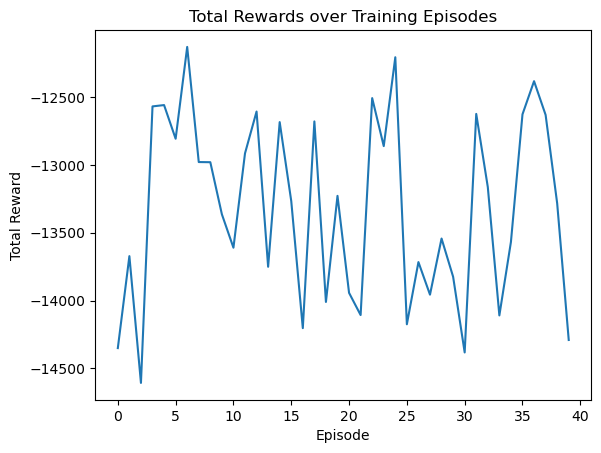

Average Reward over 100 episodes: -12605.30875028562


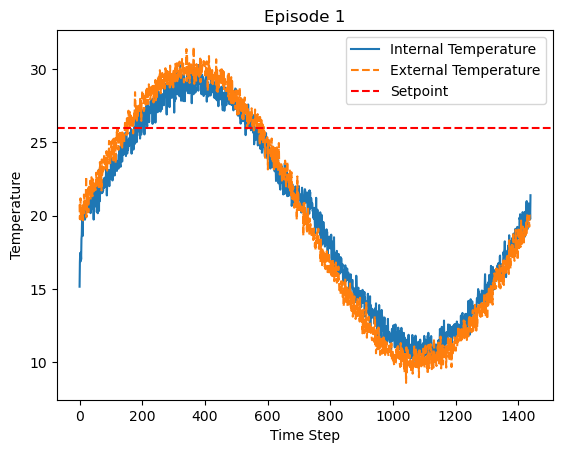

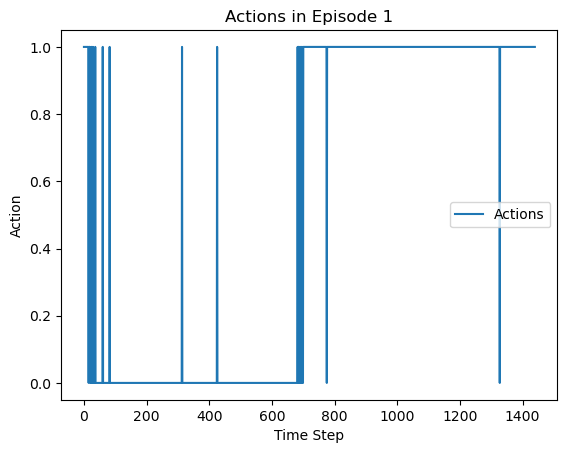

In [446]:
# Train and evaluate the DQN agent
env = RoomTemperatureControlEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)
dqn_agent.train(env, episodes=40)

# Plot training rewards
plot_training_rewards(dqn_agent.training_rewards)

# Evaluate and track performance
average_reward, rewards = dqn_agent.evaluate(env)
print(f"Average Reward over {len(rewards)} episodes: {average_reward}")
track_temperature_and_actions(dqn_agent, env)